In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import ConcatDataset
import time

USE_GPU = True
dtype = torch.float32 # We will be using float

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = -1
print('using device:', device)

path_to_store_the_plots = 'plots/flatten/'

using device: cuda


In [2]:
# Define the path to the dataset
#dataset_path = "../../../sign_datasets/sign-language-gesture-images-dataset/Gesture Image Data"
#dataset_path = "../../../sign_datasets/hagrid-classification-512p"
dataset_path = "../../../sign_datasets/hagrid-classification-512p-10-percent"
#dataset_path = ["../../../sign_datasets/american_sign_language_dataset/ASL_Dataset/Train", "../../../sign_datasets/american_sign_language_dataset/ASL_Dataset/Test"]
#dataset_path = ["../../../sign_datasets/bengali-sign-language-dataset/RESIZED_DATASET", "../../../sign_datasets/bengali-sign-language-dataset/RESIZED_TESTING_DATA"]
#dataset_path = ["../../../sign_datasets/kslc-kenyan-sign-language-dataset/train", "../../../sign_datasets/kslc-kenyan-sign-language-dataset/test"]
#dataset_path = "../../../sign_datasets/AzSL Dataset"

# Define the batch size
batch_size = 64
if isinstance(dataset_path, str):
    # Load the dataset without transformations
    dataset = datasets.ImageFolder(root=dataset_path)
    path_to_store_the_plots = path_to_store_the_plots + dataset_path.split('/')[-1]
elif isinstance(dataset_path, list):
    # Load all datasets using ImageFolder
    datasets_list = [datasets.ImageFolder(root=path) for path in dataset_path]
    # Combine all datasets
    dataset = ConcatDataset(datasets_list)
    path_to_store_the_plots = path_to_store_the_plots + dataset_path[0].split('/')[-2]

# Check if the directory exists, and create it if it doesn't
os.makedirs(path_to_store_the_plots, exist_ok=True)

print(f"Plots will be stored in: {path_to_store_the_plots}")

# Get the total number of samples
total_samples = len(dataset)
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

# Print the sizes of each split
print(f"Total samples: {total_samples}")
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Plots will be stored in: plots/hagrid-classification-512p-10-percent
Total samples: 50698
Training set size: 35488
Validation set size: 10139
Test set size: 5071


In [3]:
# Already computed mean and std
# sign-language-gesture-images-dataset/Gesture Image Data"
# computed_mean = [0.5273298025131226, 0.4507707953453064, 0.4120909869670868]
# computed_std = [0.5632718205451965, 0.5085217952728271, 0.48751917481422424]

# Hagrid
# computed_mean = [0.5778126, 0.516726, 0.48417425]
# computed_std = [0.25172076, 0.24928826, 0.24764916]

# Hagrid 10%
computed_mean = [0.5810514688491821, 0.5178735852241516, 0.48736947774887085]
computed_std = [0.6329583525657654, 0.5746501684188843, 0.5465894937515259]

# American Sign Language
# computed_mean = [0.52732987, 0.4507709, 0.41209071]
# computed_std = [0.19798545, 0.23537221, 0.26049182]

# Bengali
# computed_mean = [0.6287722587585449, 0.6092960834503174, 0.5825445055961609]
# computed_std = [0.6499956250190735, 0.6389758586883545, 0.6195625066757202]

# KSLC
# computed_mean = [0.45728039741516113, 0.40885069966316223, 0.3974429965019226]
# computed_std = [0.523685097694397, 0.47511494159698486, 0.4643438160419464]

# azsl-dataset
# computed_mean = [0.5590047240257263, 0.49885866045951843, 0.4555515944957733]
# computed_std = [0.6033478379249573, 0.5458617806434631, 0.5077916383743286]


# Build the transform pipeline
transform_list = [
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=computed_mean, std=computed_std)  # Normalize
]

if isinstance(dataset_path, str) and "AzSL" in dataset_path:
    transform_list.insert(0, transforms.Resize((224, 224)))

if isinstance(dataset_path, str) and "hagrid" in dataset_path:
    transform_list.insert(0, transforms.Resize((512, 512)))

# Create the final transform
transform = transforms.Compose(transform_list)

if isinstance(dataset_path, str):
    # Load the dataset without transformations
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    class_names = dataset.classes
elif isinstance(dataset_path, list):
    # Load all datasets using ImageFolder
    datasets_list = [datasets.ImageFolder(root=path, transform=transform) for path in dataset_path]
    # Combine all datasets
    dataset = ConcatDataset(datasets_list)
    class_names = datasets_list[0].classes

# Get class names
print("Class names:", class_names)

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Example of iterating through the train DataLoader
for images, labels in train_loader:
    print("Train Batch - Images shape:", images.shape)
    print("Train Batch - Labels shape:", labels.shape)
    break

# Print dataset sizes for verification
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

len_train_loader = len(train_loader)
len_val_loader = len(val_loader)
len_test_loader = len(test_loader)

# Print DataLoader sizes for verification
print(f"Train DataLoader size: {len(train_loader)}")
print(f"Validation DataLoader size: {len(val_loader)}")
print(f"Test DataLoader size: {len(test_loader)}")

Class names: ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted']
Train Batch - Images shape: torch.Size([64, 3, 512, 512])
Train Batch - Labels shape: torch.Size([64])
Train set size: 35488
Validation set size: 10139
Test set size: 5071
Train DataLoader size: 555
Validation DataLoader size: 159
Test DataLoader size: 80


In [4]:
# Access the first image in the dataset
image, label = train_loader.dataset[0]

# Extract dimensions
width = image.shape[1]
height = image.shape[2]

print(f"Width: {width}, Height: {height}")

Width: 512, Height: 512


In [5]:
def check_accuracy_part(loader, model, return_acc=False):

    # Determine the split type
    if len(loader) == len_train_loader:
        split = 'train'
    elif len(loader) == len_val_loader:
        split = 'val'
    elif len(loader) == len_test_loader:
        split = 'test'

    print(f'Checking accuracy on the {split} set')

    # Init counters and placeholders
    num_correct = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    # Set model to evaluation mode
    model.eval()

    # Disable gradient computation as we don't train
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # Move to device, e.g., GPU
            y = y.to(device=device, dtype=torch.long)  # Use torch.long for labels

            # Forward pass
            scores = model(x)
            _, preds = scores.max(1)  # Get predicted class -> highest score

            # Collect all predictions and labels for confusion matrix
            all_preds.append(preds.cpu())  # Append to list, move to CPU for numpy
            all_labels.append(y.cpu())    # Append to list, move to CPU for numpy

            # Count correct predictions and total samples
            correct_predictions = preds == y  # True if correct - False otherwise
            num_correct += correct_predictions.sum().item()
            num_samples += preds.size(0)

    # Compute accuracy
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

    # For test set: plot confusion matrix
    if split == 'test':
        all_preds = torch.cat(all_preds).numpy()  # Flatten and convert to numpy
        all_labels = torch.cat(all_labels).numpy()

        # Compute confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)
        np.savetxt(path_to_store_the_plots + '/confusion_matrix.txt', conf_matrix, fmt='%d')

        # Plot confusion matrix
        plt.figure(figsize=(20, 20))
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt='d',
            cmap='Greens',
            linewidths=0.5,
            xticklabels=class_names,
            yticklabels=class_names
        )
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix with Actual Class Labels')
        plt.savefig(path_to_store_the_plots + '/confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

    if return_acc:
        return 100 * acc

In [6]:
def train_part(model, optimizer, epochs=1, scheduler = None, return_acc = False, check_train_set = False, check_test_set = False):
    
    # List to store validation and train accuracies at each epoch where needed
    val_accs = []
    train_accs = []
    losses = []
    val_losses = [] 
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t+1 % print_every == 0 and print_every!=-1 :
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part(val_loader, model)
                print()
                
        losses.append(loss.item())
        print(f"Training Loss after epoch {e+1}: {loss.item()}")
        # Step the scheduler after each epoch to adjust the learning rate if needed
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                # If the scheduler is of type ReduceLROnPlateau, use validation loss for adjustment
                model.eval()  # Set model to evaluation mode
                val_loss = 0.0  # Initialize validation loss accumulator
                with torch.no_grad():  # No need to compute gradients during validation
                    for data, target in val_loader:
                        data, target = data.to(device=device, dtype=dtype), target.to(device=device, dtype=torch.long)
                        output = model(data)
                        loss = F.cross_entropy(output, target)
                        val_loss += loss.item()  # Accumulate the validation loss

                val_loss /= len(val_loader)  # Average the validation loss
                scheduler.step(val_loss)  # Step the scheduler based on the validation loss
            else:
                scheduler.step()  # Step the scheduler for other types of schedulers

        # Calculate validation loss for the epoch
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device=device, dtype=dtype), target.to(device=device, dtype=torch.long)
                output = model(data)
                loss = F.cross_entropy(output, target)
                val_loss += loss.item()
        val_loss /= len(val_loader)  # Average validation loss
        val_losses.append(val_loss)  # Append validation loss to list
        
        # After each epoch, check accuracies
        val_acc = check_accuracy_part(val_loader, model, return_acc=True)
        val_accs.append(val_acc)
        
        print(f"Validation Accuracy after epoch {e+1}: {val_acc:.2f}%")
        print(f"Validation Loss after epoch {e+1}: {val_loss:.2f}")
        
        # Return accuracies if requested
        if check_train_set:
            train_acc = check_accuracy_part(train_loader, model, return_acc=True)
            train_accs.append(train_acc)
            print(f"Training Accuracy after epoch {e+1}: {train_acc:.2f}%")

    # Return accuracies if requested
    if return_acc:
        if check_train_set and check_test_set:
            test_acc = check_accuracy_part(test_loader, model, return_acc=True)  # Check test set accuracy
            return val_accs, train_accs, test_acc, losses, val_losses  # Return the most recent validation accuracy and the test accuracy
        if check_train_set:  # If requested, return both validation and training accuracies
            return val_accs, train_accs, losses, val_losses
        if check_test_set:  # If requested, return the validation accuracy and test accuracy
            test_acc = check_accuracy_part(test_loader, model, return_acc=True)  # Check test set accuracy
            return val_accs, test_acc, losses, val_losses  # Return the most recent validation accuracy and the test accuracy
        return val_accs, losses, val_losses  # Return only validation accuracies if no other set (train or test) is specified

In [7]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

Training Loss after epoch 1: 2.6666040420532227
Checking accuracy on the val set
Got 1627 / 10139 correct (16.05%)
Validation Accuracy after epoch 1: 16.05%
Validation Loss after epoch 1: 2.78
Checking accuracy on the train set
Got 7417 / 35488 correct (20.90%)
Training Accuracy after epoch 1: 20.90%
Training Loss after epoch 2: 2.4734199047088623
Checking accuracy on the val set
Got 1950 / 10139 correct (19.23%)
Validation Accuracy after epoch 2: 19.23%
Validation Loss after epoch 2: 2.64
Checking accuracy on the train set
Got 9501 / 35488 correct (26.77%)
Training Accuracy after epoch 2: 26.77%
Training Loss after epoch 3: 2.1466658115386963
Checking accuracy on the val set
Got 2010 / 10139 correct (19.82%)
Validation Accuracy after epoch 3: 19.82%
Validation Loss after epoch 3: 2.60
Checking accuracy on the train set
Got 11868 / 35488 correct (33.44%)
Training Accuracy after epoch 3: 33.44%
Training Loss after epoch 4: 2.3570516109466553
Checking accuracy on the val set
Got 2064 / 1

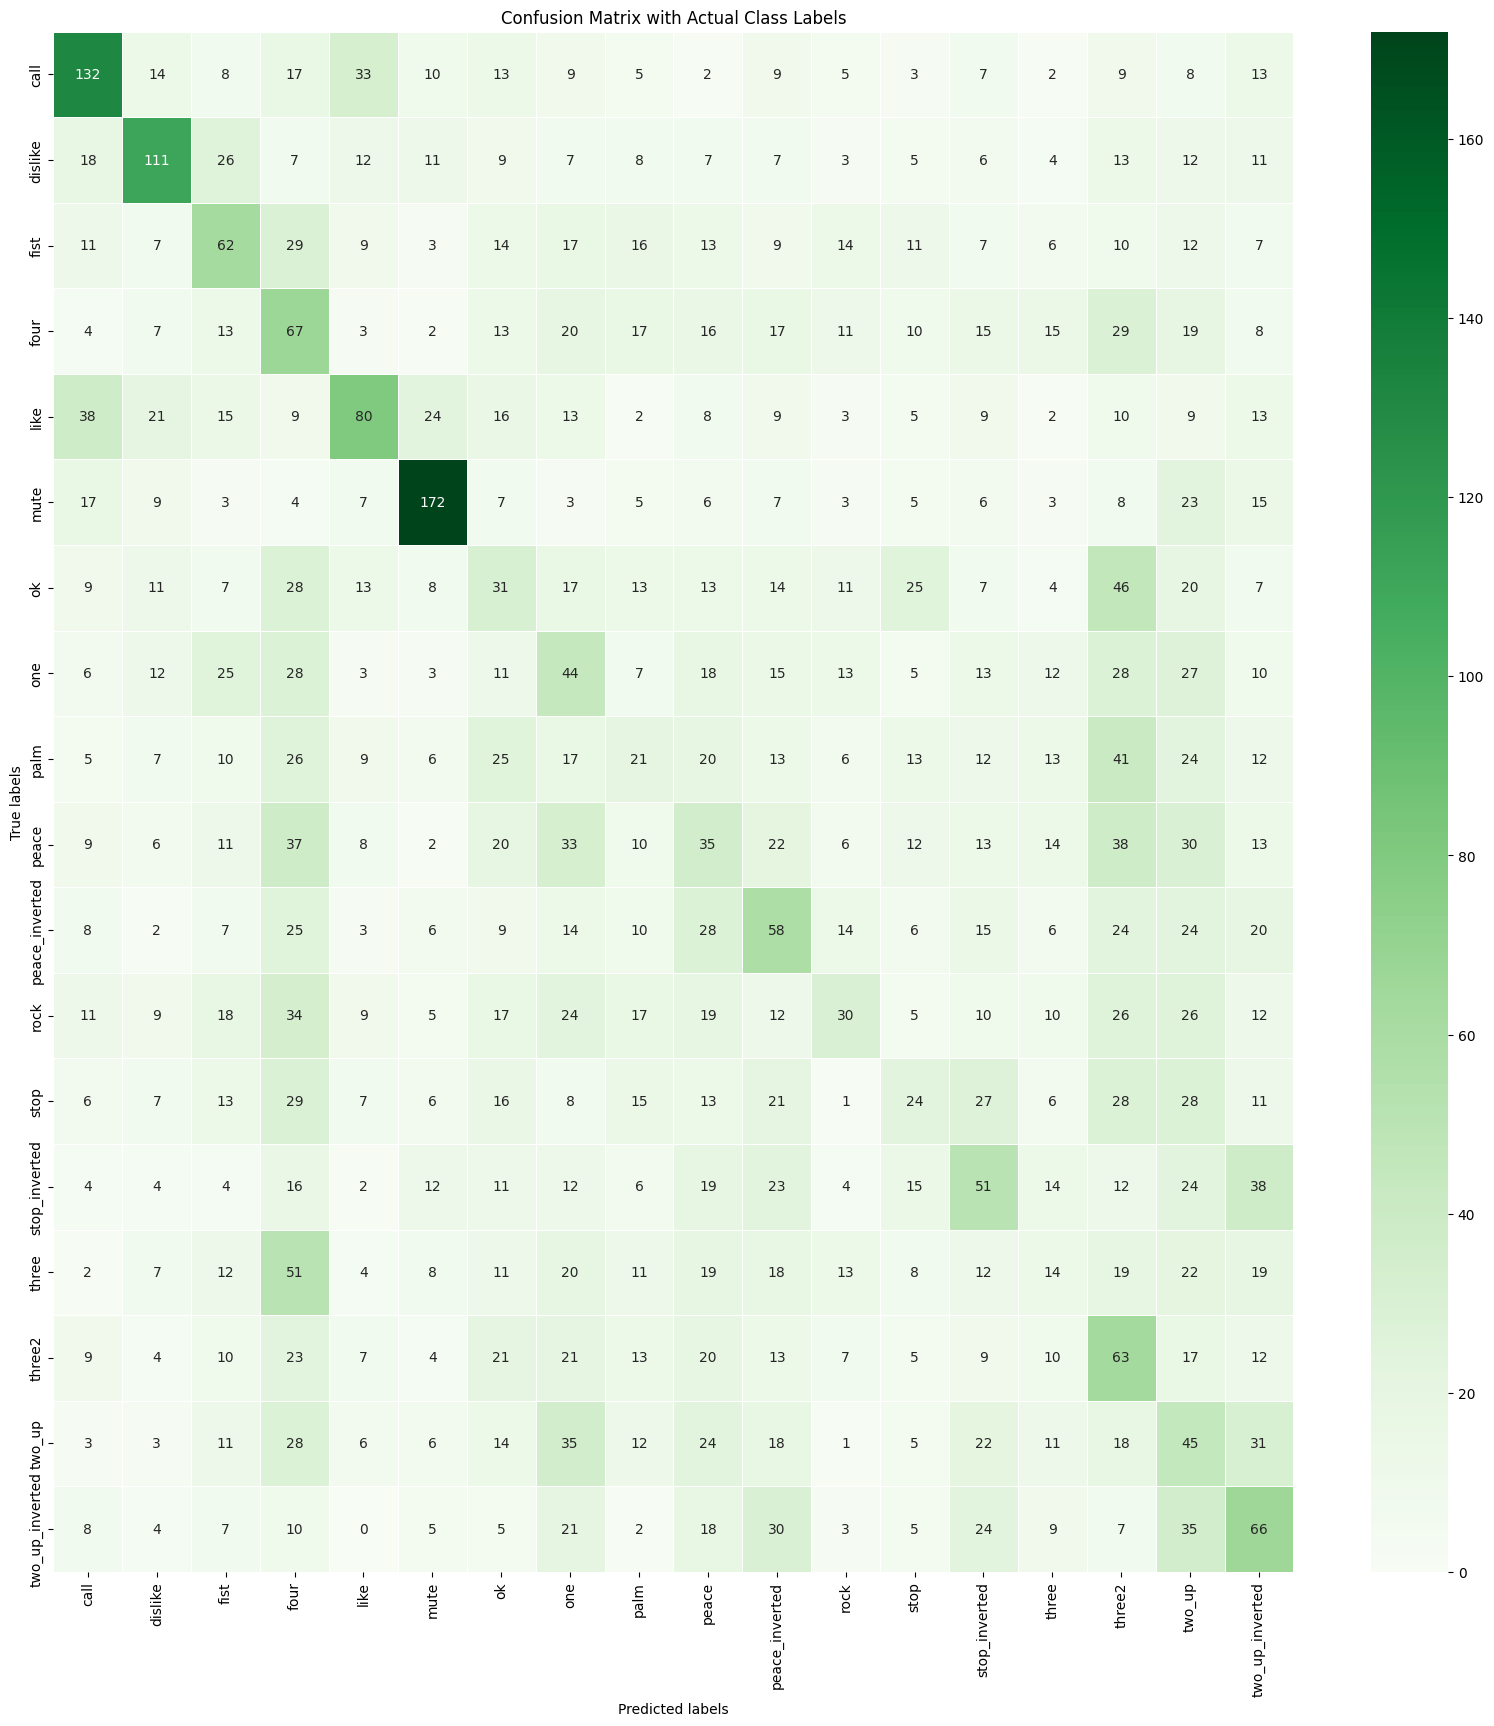


########### Final Results ###########
Elapsed Time: 12947.88 seconds
Validation Accuracy: 21.67866653516126
Test Accuracy: 21.810293827647406


In [8]:
hidden_layer_size = 500
learning_rate = 1e-3
num_classes = len(class_names)

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * width * height, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, num_classes),
)

model = model.to(device=device)


# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

# Start the timer
start_time = time.time()
val_accs, train_accs, test_acc, losses, val_losses = train_part(model, optimizer,epochs=20, return_acc=True, check_train_set = True, check_test_set = True)
# Stop the timer
elapsed_time = time.time() - start_time

# Print the validation and test accuracies
print()
print('########### Final Results ###########')
print("Elapsed Time: {:.2f} seconds".format(elapsed_time))
print("Validation Accuracy:", val_accs[-1])
print("Test Accuracy:", test_acc)

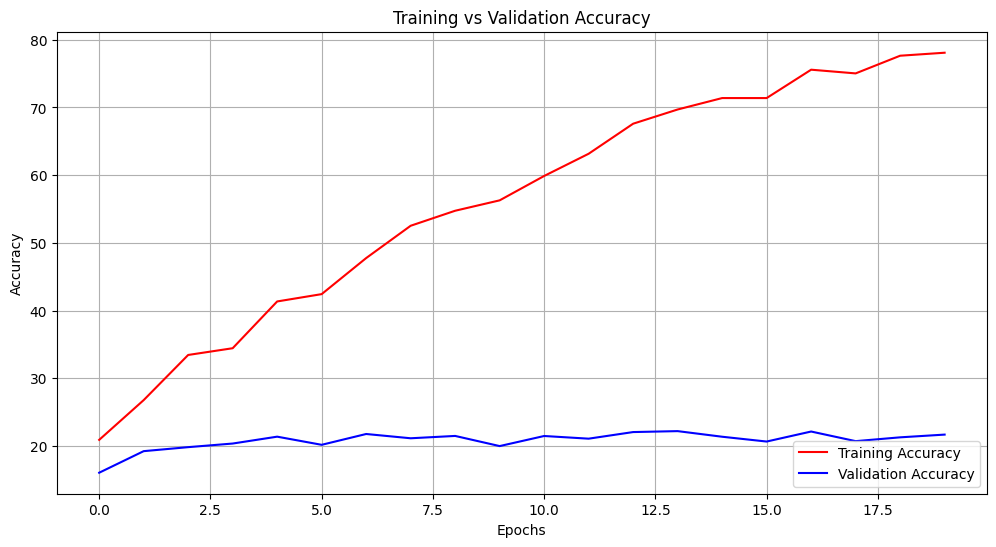

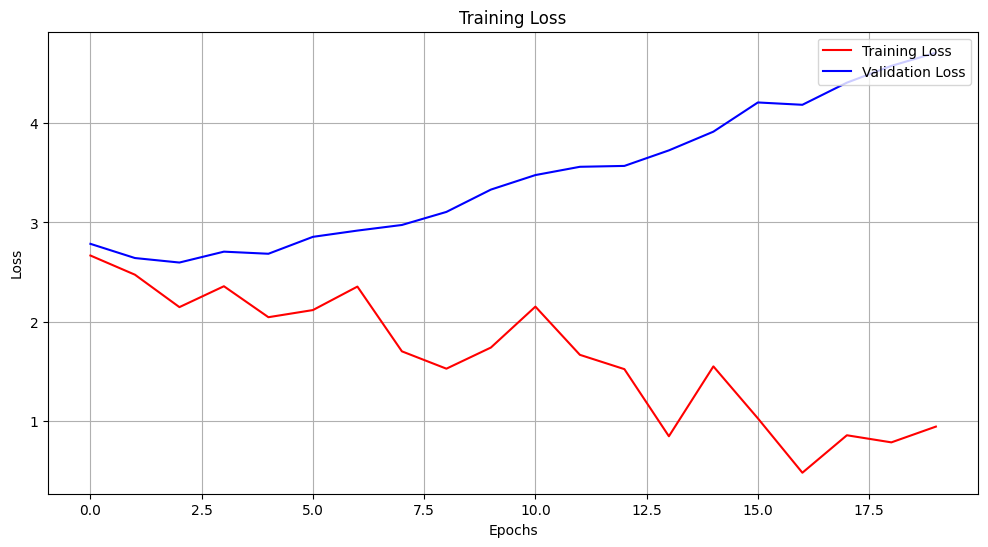

In [9]:
# Plot accuracy
epochs = range(len(val_accs))
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accs, 'r', label='Training Accuracy')
plt.plot(epochs, val_accs, 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(path_to_store_the_plots + '/Accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, losses, 'r', label='Training Loss')
plt.plot(epochs, val_losses, 'b', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig(path_to_store_the_plots + '/Loss.png', dpi=300, bbox_inches='tight')
plt.show()